In [122]:
from sympy import *
import numpy as np
from IPython.display import display, Math, Latex
import matplotlib.pyplot as plt

In [10]:
# Defining symbols
H, B, HB, H2B, H3B = symbols(r'[H^{+}], [B^{3-}], [HB^{2-}], [H_{2}B^-], [H_{3}B]',
                                           positive=True, real=True)
K_1, K_2, K_3, K_1_pr, K_2_pr, K_3_pr = symbols(r'K_1, K_2, K_3, K_1^{\prime}, K_2^{\prime}, K_3^{\prime}',
                                           positive=True, real=True)
kf_1, kb_1, kf_2, kb_2 = symbols(r'k_f^1, k_b^1, k_f^2, k_b^2',
                                 positive=True, real=True)
y_H, y_H3B, y_H2B, y_HB, y_B = symbols(r'y_{H^+}, y_{H_{3}B}, y_{H_{2}B^-}, y_{HB^{2-}}, y_{B^{3-}}',
                                   positive=True, real=True)
I, pH, C_t, C_sup = symbols(r'I, pH, C_{total}, C_{sup}',
                    positive=True, real=True)

In [11]:
class AcidBaseEquilibrium:
    def __init__(self, C_tot, pH0, pK_values, I_add = 0):
        self.C_tot = C_tot
        self.pH0 = pH0
        self.pK_values = pK_values
        self.I_add = I_add
        self.num_pK = len(pK_values)
        self.y_H_expr = 10**(-0.5115*1*((sqrt(I) / (1+sqrt(I))) - 0.3*I))
        self.y_H3B_expr = 10**(-0.5115*0*((sqrt(I) / (1+sqrt(I))) - 0.3*I))
        self.y_H2B_expr = 10**(-0.5115*1*((sqrt(I) / (1+sqrt(I))) - 0.3*I))
        self.y_HB_expr = 10**(-0.5115*4*((sqrt(I) / (1+sqrt(I))) - 0.3*I))
        self.y_B_expr = 10**(-0.5115*9*((sqrt(I) / (1+sqrt(I))) - 0.3*I))
        
        #self.K_1_expr = (H * H2B / H3B) * (y_H * y_H2B / y_H3B)
        #self.K_2_expr = (H * HB / H2B) * (y_H * y_HB / y_H2B)
        #self.K_3_expr = (H * B / HB) * (y_H * y_B / y_HB)
        self.real_params = {C_t: C_tot,
                            pH: pH0}
        
        if self.num_pK == 1:
            self.init_monoacid()
        elif self.num_pK == 2:
            self.init_diacid()
        elif self.num_pK == 3:
            self.init_triacid()
        else:
            raise ValueError("Supported only from 1 to 3 pKa values")
            
    def init_monoacid(self):
        global H2B, H3B, y_H2B, y_H3B
        H2B, H3B = symbols(r'[B^{-}], [HB]', positive=True, real=True)
        y_H2B, y_H3B = symbols(r'y_{B^{-}}, y_{HB}', positive=True, real=True)
        display(Latex(r"Expression for the ionic force according to $I=\frac{1}{2} \sum_{i}{c_i z_i^2}$ is:"))
        self.I_expr = 0.5*(H3B*0 + H2B*1 + (0*H3B + H2B)*1) + self.I_add
        display(Eq(I, self.I_expr))
        display(Latex(r"The Davies activity coefficients for the species according to $\log \gamma_i=-A z_i^2\left(\frac{\sqrt{I}}{1+\sqrt{I}}-0.3 I\right)$ are:"))
        display(Eq(y_H, self.y_H_expr))
        display(Eq(y_H3B, self.y_H3B_expr))
        display(Eq(y_H2B, self.y_H2B_expr))
        K_1_expr = (H * H2B / H3B) * (y_H * y_H2B / y_H3B)
        Eq1 = Eq(K_1, K_1_expr)
        print("We will solve the following system of equations:")
        display(Eq(H2B+H3B, C_t), Eq1)
        init_subs = {y_H3B: self.y_H3B_expr,
                     y_H2B: self.y_H2B_expr,
                     H: 10**(-pH)/y_H,
                     y_H: self.y_H_expr}
        
        Eq1_complete = Eq1.subs(init_subs)
        self.real_params.update({K_1: 10**(-self.pK_values[0])})
        self.dummy_system =[eq.subs(self.real_params).subs(I, 0) for eq in [Eq(H2B+H3B, C_t), Eq1_complete]]
        self.system =[eq.subs(self.real_params).subs(I, self.I_expr) for eq in [Eq(H2B+H3B, C_t), Eq1_complete]]
        #display(self.system)
        
    def init_diacid(self):
        global HB, H2B, H3B, y_HB, y_H2B, y_H3B
        HB, H2B, H3B = symbols(r'[B^{2-}], [HB^{-}], [H_{2}B]', positive=True, real=True)
        y_HB, y_H2B, y_H3B = symbols(r'y_{B^{2-}}, y_{HB^{-}}, y_{H_{2}B}', positive=True, real=True)
        display(Latex(r"Expression for the ionic force according to $I=\frac{1}{2} \sum_{i}{c_i z_i^2}$ is:"))
        self.I_expr = 0.5*(H3B*0 + H2B*1 + HB*4 + (0*H3B + H2B + 2*HB)*1) + self.I_add
        display(Eq(I, self.I_expr))
        display(Latex(r"The Davies activity coefficients for the species according to $\log \gamma_i=-A z_i^2\left(\frac{\sqrt{I}}{1+\sqrt{I}}-0.3 I\right)$ are:"))
        display(Eq(y_H, self.y_H_expr))
        display(Eq(y_H3B, self.y_H3B_expr))
        display(Eq(y_H2B, self.y_H2B_expr))
        display(Eq(y_HB, self.y_HB_expr))
        K_1_expr = (H * H2B / H3B) * (y_H * y_H2B / y_H3B)
        K_2_expr = (H * HB / H2B) * (y_H * y_HB / y_H2B)
        Eq1 = Eq(K_1, K_1_expr)
        Eq2 = Eq(K_2, K_2_expr)
        print("We will solve the following system of equations:")
        display(Eq(H2B+H3B+HB, C_t), Eq1, Eq2)
        init_subs = {y_H3B: self.y_H3B_expr,
                     y_H2B: self.y_H2B_expr,
                     y_HB: self.y_HB_expr,
                     H: 10**(-pH)/y_H,
                     y_H: self.y_H_expr}
        Eq1_complete = Eq1.subs(init_subs)
        Eq2_complete = Eq2.subs(init_subs)
        self.real_params.update({K_1: 10**(-self.pK_values[0]),
                                K_2: 10**(-self.pK_values[1])})
        self.dummy_system =[eq.subs(self.real_params).subs(I, 0) for eq in [Eq(H2B+H3B+HB, C_t), Eq1_complete, Eq2_complete]]
        self.system =[eq.subs(self.real_params).subs(I, self.I_expr) for eq in [Eq(H2B+H3B+HB, C_t), Eq1_complete, Eq2_complete]]
        #display(self.system)

    def init_triacid(self):
        global B, HB, H2B, H3B, y_B, y_HB, y_H2B, y_H3B
        B, HB, H2B, H3B = symbols(r'[B^{3-}], [HB^{2-}], [H_{2}B^{-}], [H_{3}B]', positive=True, real=True)
        y_B, y_HB, y_H2B, y_H3B = symbols(r'y_{B^{3-}}, y_{HB^{2-}}, y_{H_{2}B^{-}}, y_{H_{3}B}', positive=True, real=True)
        display(Latex(r"Expression for the ionic force according to $I=\frac{1}{2} \sum_{i}{c_i z_i^2}$ is:"))
        self.I_expr = 0.5*(H3B*0 + H2B*1 + HB*4 + B*9 + (0*H3B + H2B + 2*HB + 3*B)*1) + self.I_add
        display(Eq(I, self.I_expr))
        display(Latex(r"The Davies activity coefficients for the species according to $\log \gamma_i=-A z_i^2\left(\frac{\sqrt{I}}{1+\sqrt{I}}-0.3 I\right)$ are:"))
        display(Eq(y_H, self.y_H_expr))
        display(Eq(y_H3B, self.y_H3B_expr))
        display(Eq(y_H2B, self.y_H2B_expr))
        display(Eq(y_HB, self.y_HB_expr))
        display(Eq(y_B, self.y_B_expr))
        K_1_expr = (H * H2B / H3B) * (y_H * y_H2B / y_H3B)
        K_2_expr = (H * HB / H2B) * (y_H * y_HB / y_H2B)
        K_3_expr = (H * B / HB) * (y_H * y_B / y_HB)
        Eq1 = Eq(K_1, K_1_expr)
        Eq2 = Eq(K_2, K_2_expr)
        Eq3 = Eq(K_3, K_3_expr)
        print("We will solve the following system of equations:")
        display(Eq(H2B+H3B+HB+B, C_t), Eq1, Eq2, Eq3)
        init_subs = {y_H3B: self.y_H3B_expr,
                     y_H2B: self.y_H2B_expr,
                     y_HB: self.y_HB_expr,
                     y_B: self.y_B_expr,
                     H: 10**(-pH)/y_H,
                     y_H: self.y_H_expr}
        Eq1_complete = Eq1.subs(init_subs)
        Eq2_complete = Eq2.subs(init_subs)
        Eq3_complete = Eq3.subs(init_subs)
        self.real_params.update({K_1: 10**(-self.pK_values[0]),
                                K_2: 10**(-self.pK_values[1]),
                                K_3: 10**(-self.pK_values[2])})
        self.dummy_system =[eq.subs(self.real_params).subs(I, 0) for eq in [Eq(H2B+H3B+HB+B, C_t), Eq1_complete, Eq2_complete, Eq3_complete]]
        self.system =[eq.subs(self.real_params).subs(I, self.I_expr) for eq in [Eq(H2B+H3B+HB+B, C_t), Eq1_complete, Eq2_complete, Eq3_complete]]
        #display(self.system)
        
    def solve_dummy(self):
        if not hasattr(self, 'dummy_solution'):
            self.dummy_solution = solve(self.dummy_system, dict=True)[0]
        #display(self.dummy_solution)
        
    def solve(self):
        self.solve_dummy()
        if self.num_pK == 1:
            solution = nsolve(self.system, (H3B, H2B), (self.dummy_solution[H3B], self.dummy_solution[H2B]), dict=True, prec=20)[0]
        elif self.num_pK == 2:
            solution = nsolve(self.system, (H3B, H2B, HB), (self.dummy_solution[H3B], self.dummy_solution[H2B], self.dummy_solution[HB]), dict=True, prec=20)[0]
        elif self.num_pK == 3:
            solution = nsolve(self.system, (H3B, H2B, HB, B), (self.dummy_solution[H3B], self.dummy_solution[H2B], self.dummy_solution[HB], self.dummy_solution[B]), dict=True, prec=20)[0]
        for k,v in solution.items():
            display(Latex(fr"The concentration of ${latex(k)}$ is: {v} M"))
        ion_str = self.I_expr.subs(solution)
        display(Latex(fr"The concentration of ${latex(H)}$ is: {10**(-self.pH0)/self.y_H_expr.subs(I, ion_str)} M"))  

In [185]:
class AcidBaseEquilibrium:
    def __init__(self, C_tot, pH0, pK_values, I_add = 0):
        self.C_tot = C_tot
        self.pH0 = pH0
        self.pK_values = pK_values
        self.I_add = I_add
        self.num_pK = len(pK_values)
        self.y_H_expr = 10**(-0.5115*1*((sqrt(I) / (1+sqrt(I))) - 0.3*I))
        self.y_H3B_expr = 10**(-0.5115*0*((sqrt(I) / (1+sqrt(I))) - 0.3*I))
        self.y_H2B_expr = 10**(-0.5115*1*((sqrt(I) / (1+sqrt(I))) - 0.3*I))
        self.y_HB_expr = 10**(-0.5115*4*((sqrt(I) / (1+sqrt(I))) - 0.3*I))
        self.y_B_expr = 10**(-0.5115*9*((sqrt(I) / (1+sqrt(I))) - 0.3*I))
        
        #self.K_1_expr = (H * H2B / H3B) * (y_H * y_H2B / y_H3B)
        #self.K_2_expr = (H * HB / H2B) * (y_H * y_HB / y_H2B)
        #self.K_3_expr = (H * B / HB) * (y_H * y_B / y_HB)
        self.real_params = {C_t: C_tot,
                            pH: pH0}
        
        if self.num_pK == 1:
            self.init_monoacid()
        elif self.num_pK == 2:
            self.init_diacid()
        elif self.num_pK == 3:
            self.init_triacid()
        else:
            raise ValueError("Supported only from 1 to 3 pKa values")
            
    def init_monoacid(self):
        global H2B, H3B, y_H2B, y_H3B
        H2B, H3B = symbols(r'[B^{-}], [HB]', positive=True, real=True)
        y_H2B, y_H3B = symbols(r'y_{B^{-}}, y_{HB}', positive=True, real=True)
        display(Latex(r"Expression for the ionic force according to $I=\frac{1}{2} \sum_{i}{c_i z_i^2}$ is:"))
        self.I_expr = 0.5*(H3B*0 + H2B*1 + (0*H3B + H2B)*1) + self.I_add
        display(Eq(I, self.I_expr))
        display(Latex(r"The Davies activity coefficients for the species according to $\log \gamma_i=-A z_i^2\left(\frac{\sqrt{I}}{1+\sqrt{I}}-0.3 I\right)$ are:"))
        display(Eq(y_H, self.y_H_expr))
        display(Eq(y_H3B, self.y_H3B_expr))
        display(Eq(y_H2B, self.y_H2B_expr))
        K_1_expr = (H * H2B / H3B) * (y_H * y_H2B / y_H3B)
        Eq1 = Eq(K_1, K_1_expr)
        print("We will solve the following system of equations:")
        display(Eq(H2B+H3B, C_t), Eq1)
        init_subs = {H: 10**(-pH)/y_H,
                     y_H3B: self.y_H3B_expr,
                     y_H2B: self.y_H2B_expr,
                     y_H: self.y_H_expr}
        
        Eq1_complete = Eq1.subs(init_subs).subs({K_1: 10**(-self.pK_values[0])})
        self.dummy_system =[eq.subs(I, 0) for eq in [Eq(H2B+H3B, C_t), Eq1_complete]]
        self.system =[eq.subs(I, self.I_expr) for eq in [Eq(H2B+H3B, C_t), Eq1_complete]]
        #display(self.system)
        
    def init_diacid(self):
        global HB, H2B, H3B, y_HB, y_H2B, y_H3B
        HB, H2B, H3B = symbols(r'[B^{2-}], [HB^{-}], [H_{2}B]', positive=True, real=True)
        y_HB, y_H2B, y_H3B = symbols(r'y_{B^{2-}}, y_{HB^{-}}, y_{H_{2}B}', positive=True, real=True)
        display(Latex(r"Expression for the ionic force according to $I=\frac{1}{2} \sum_{i}{c_i z_i^2}$ is:"))
        self.I_expr = 0.5*(H3B*0 + H2B*1 + HB*4 + (0*H3B + H2B + 2*HB)*1) + self.I_add
        display(Eq(I, self.I_expr))
        display(Latex(r"The Davies activity coefficients for the species according to $\log \gamma_i=-A z_i^2\left(\frac{\sqrt{I}}{1+\sqrt{I}}-0.3 I\right)$ are:"))
        display(Eq(y_H, self.y_H_expr))
        display(Eq(y_H3B, self.y_H3B_expr))
        display(Eq(y_H2B, self.y_H2B_expr))
        display(Eq(y_HB, self.y_HB_expr))
        K_1_expr = (H * H2B / H3B) * (y_H * y_H2B / y_H3B)
        K_2_expr = (H * HB / H2B) * (y_H * y_HB / y_H2B)
        Eq1 = Eq(K_1, K_1_expr)
        Eq2 = Eq(K_2, K_2_expr)
        print("We will solve the following system of equations:")
        display(Eq(H2B+H3B+HB, C_t), Eq1, Eq2)
        init_subs = {y_H3B: self.y_H3B_expr,
                     y_H2B: self.y_H2B_expr,
                     y_HB: self.y_HB_expr,
                     H: 10**(-pH)/y_H,
                     y_H: self.y_H_expr}
        Eq1_complete = Eq1.subs(init_subs).subs({K_1: 10**(-self.pK_values[0]),
                                                K_2: 10**(-self.pK_values[1])})
        Eq2_complete = Eq2.subs(init_subs).subs({K_1: 10**(-self.pK_values[0]),
                                                K_2: 10**(-self.pK_values[1])})
        self.dummy_system =[eq.subs(I, 0) for eq in [Eq(H2B+H3B+HB, C_t), Eq1_complete, Eq2_complete]]
        self.system =[eq.subs(I, self.I_expr) for eq in [Eq(H2B+H3B+HB, C_t), Eq1_complete, Eq2_complete]]
        #display(self.system)

    def init_triacid(self):
        global B, HB, H2B, H3B, y_B, y_HB, y_H2B, y_H3B
        B, HB, H2B, H3B = symbols(r'[B^{3-}], [HB^{2-}], [H_{2}B^{-}], [H_{3}B]', positive=True, real=True)
        y_B, y_HB, y_H2B, y_H3B = symbols(r'y_{B^{3-}}, y_{HB^{2-}}, y_{H_{2}B^{-}}, y_{H_{3}B}', positive=True, real=True)
        display(Latex(r"Expression for the ionic force according to $I=\frac{1}{2} \sum_{i}{c_i z_i^2}$ is:"))
        self.I_expr = 0.5*(H3B*0 + H2B*1 + HB*4 + B*9 + (0*H3B + H2B + 2*HB + 3*B)*1) + self.I_add
        display(Eq(I, self.I_expr))
        display(Latex(r"The Davies activity coefficients for the species according to $\log \gamma_i=-A z_i^2\left(\frac{\sqrt{I}}{1+\sqrt{I}}-0.3 I\right)$ are:"))
        display(Eq(y_H, self.y_H_expr))
        display(Eq(y_H3B, self.y_H3B_expr))
        display(Eq(y_H2B, self.y_H2B_expr))
        display(Eq(y_HB, self.y_HB_expr))
        display(Eq(y_B, self.y_B_expr))
        K_1_expr = (H * H2B / H3B) * (y_H * y_H2B / y_H3B)
        K_2_expr = (H * HB / H2B) * (y_H * y_HB / y_H2B)
        K_3_expr = (H * B / HB) * (y_H * y_B / y_HB)
        Eq1 = Eq(K_1, K_1_expr)
        Eq2 = Eq(K_2, K_2_expr)
        Eq3 = Eq(K_3, K_3_expr)
        print("We will solve the following system of equations:")
        display(Eq(H2B+H3B+HB+B, C_t), Eq1, Eq2, Eq3)
        init_subs = {y_H3B: self.y_H3B_expr,
                     y_H2B: self.y_H2B_expr,
                     y_HB: self.y_HB_expr,
                     y_B: self.y_B_expr,
                     H: 10**(-pH)/y_H,
                     y_H: self.y_H_expr}
        Eq1_complete = Eq1.subs(init_subs).subs({K_1: 10**(-self.pK_values[0]),
                                                K_2: 10**(-self.pK_values[1]),
                                                K_3: 10**(-self.pK_values[2])})
        Eq2_complete = Eq2.subs(init_subs).subs({K_1: 10**(-self.pK_values[0]),
                                                K_2: 10**(-self.pK_values[1]),
                                                K_3: 10**(-self.pK_values[2])})
        Eq3_complete = Eq3.subs(init_subs).subs({K_1: 10**(-self.pK_values[0]),
                                                K_2: 10**(-self.pK_values[1]),
                                                K_3: 10**(-self.pK_values[2])})

        self.dummy_system =[eq.subs(I, 0) for eq in [Eq(H2B+H3B+HB+B, C_t), Eq1_complete, Eq2_complete, Eq3_complete]]
        self.system =[eq.subs(I, self.I_expr) for eq in [Eq(H2B+H3B+HB+B, C_t), Eq1_complete, Eq2_complete, Eq3_complete]]
        #display(self.system)
        
    def solve_dummy(self, C_tot, pH0):
        dummy_system_complete = [eq.subs({C_t: C_tot, pH: pH0}) for eq in self.dummy_system]
        self.dummy_solution = solve(dummy_system_complete, dict=True)[0]
        #display(self.dummy_solution)
        
    def solve_single(self, C_tot, pH0, verbose=True):
        self.solve_dummy(C_tot, pH0)
        system_complete = [eq.subs({C_t: C_tot, pH: pH0}) for eq in self.system]
        if self.num_pK == 1:
            solution = nsolve(system_complete, (H3B, H2B), (self.dummy_solution[H3B], self.dummy_solution[H2B]), dict=True, prec=20)[0]
        elif self.num_pK == 2:
            solution = nsolve(system_complete, (H3B, H2B, HB), (self.dummy_solution[H3B], self.dummy_solution[H2B], self.dummy_solution[HB]), dict=True, prec=20)[0]
        elif self.num_pK == 3:
            solution = nsolve(system_complete, (H3B, H2B, HB, B), (self.dummy_solution[H3B], self.dummy_solution[H2B], self.dummy_solution[HB], self.dummy_solution[B]), dict=True, prec=20)[0]
        
        ion_str = self.I_expr.subs(solution)
        solution.update({H: 10.0**(-pH0)/self.y_H_expr.subs(I, ion_str)})
        if verbose:
            for k,v in solution.items():
                display(Latex(fr"The concentration of ${latex(k)}$ is: {v} M"))
        else:
            return solution
        #print(f"Ionic strength is {ion_str}")

    def solve_range(self, C_tot = [0.01, 0.02, 0.01], pH0 = [3, 9, 0.1]):
        C_range = np.arange(*C_tot)
        pH_range = np.arange(*pH0)
        result = []
        for c in C_range:
            for pH in pH_range:
                solution = self.solve_single(c, pH, verbose=False)
                solution_list = [solution[k] for k in solution]
                result.append([c, pH, *solution_list])
                """
                if not all(key in result for key in solution):
                    for k,v in solution.items():
                        result[k] = [v]
                        result['pH'] = [pH]
                        result['C_tot'] = [c]
                else:
                    for k,v in solution.items():
                        result[k].append(v)
                        result['pH'].append(pH)
                        result['C_tot'].append(c)
                """
        result = np.asarray(result)
        fig, axes = plt.subplots(nrows=C_range.size, ncols=1, figsize=(16, 12))
        for i, cc in enumerate(C_range):
            for sp in range(result.shape[1]-2):
                axes[i].plot(result[result[:,0] == cc, 1], result[result[:,0] == cc, sp+2])
        plt.show()
        
        return np.asarray(result)

In [189]:
# defining the buffer system
buffer = AcidBaseEquilibrium(C_tot = 0.1,                # Total buffer concentration in M
                             pH0 = 5.5,                  # Initial pH 
                             pK_values = [2.14, 7.2, 12.37],      # List of 1-3 pKa in the increasing order
                             I_add = 0)                  # Additional ionic strength from supporting electrolyte, if present

<IPython.core.display.Latex object>

False

<IPython.core.display.Latex object>

Eq(y_{H^+}, 10**(-0.5115*sqrt(I)/(1 + sqrt(I)) + 0.15345*I))

Eq(y_{H_{3}B}, 1)

Eq(y_{H_{2}B^{-}}, 10**(-0.5115*sqrt(I)/(1 + sqrt(I)) + 0.15345*I))

Eq(y_{HB^{2-}}, 10**(-2.046*sqrt(I)/(1 + sqrt(I)) + 0.6138*I))

Eq(y_{B^{3-}}, 10**(-4.6035*sqrt(I)/(1 + sqrt(I)) + 1.38105*I))

We will solve the following system of equations:


Eq([B^{3-}] + [HB^{2-}] + [H_{2}B^{-}] + [H_{3}B], C_{total})

Eq(K_1, [H^{+}]*[H_{2}B^{-}]*y_{H^+}*y_{H_{2}B^{-}}/([H_{3}B]*y_{H_{3}B}))

Eq(K_2, [HB^{2-}]*[H^{+}]*y_{HB^{2-}}*y_{H^+}/([H_{2}B^{-}]*y_{H_{2}B^{-}}))

Eq(K_3, [B^{3-}]*[H^{+}]*y_{B^{3-}}*y_{H^+}/([HB^{2-}]*y_{HB^{2-}}))

In [190]:
# Calculating the initial concentrations:
res = buffer.solve_single(C_tot = 0.1, pH0 = 2, verbose=False)
res

{[H_{3}B]: 0.053231930537141688677,
 [H_{2}B^{-}]: 0.046767543128681475386,
 [HB^{2-}]: 5.2633417678258640689e-7,
 [B^{3-}]: 5.8901080851761932383e-17,
 [H^{+}]: 0.012127529469164190934}

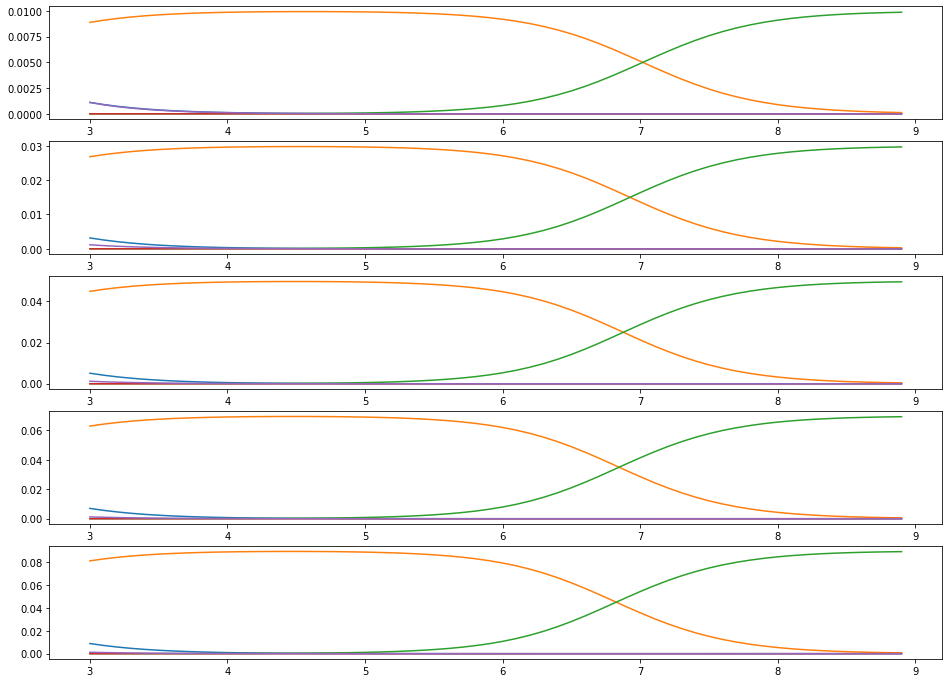

In [191]:
res = buffer.solve_range(C_tot=[0.01, 0.1, 0.02])
